In [1]:
#Best Library for Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("fivethirtyeight")

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error

# Regression
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

In [2]:
def metric(y,y0):
    assert len(y)==len(y0)
    return 100-np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0),2)))

def metric_lgb(y_pred,data):
    y_true = data.get_label()
    result = metric(y_true,y_pred)
    
    return '100-rmse', result,True

## Importing Data

In [3]:
train_1 = pd.read_csv("train.csv")
test_1 = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

print("Train Shape : {}\nTest Shape: {}\nSub Shape: {}".format(train_1.shape, test_1.shape, sub.shape))

Train Shape : (10000, 12)
Test Shape: (2500, 11)
Sub Shape: (10, 2)


In [4]:
train = train_1.copy()
test = test_1.copy()

In [5]:
train.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Severity                   10000 non-null object
Safety_Score               10000 non-null float64
Days_Since_Inspection      10000 non-null int64
Total_Safety_Complaints    10000 non-null int64
Control_Metric             10000 non-null float64
Turbulence_In_gforces      10000 non-null float64
Cabin_Temperature          10000 non-null float64
Accident_Type_Code         10000 non-null int64
Max_Elevation              10000 non-null float64
Violations                 10000 non-null int64
Adverse_Weather_Metric     10000 non-null float64
Accident_ID                10000 non-null int64
dtypes: float64(6), int64(5), object(1)
memory usage: 937.6+ KB


In [7]:
train.describe()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,41.876406,12.931100,6.564300,65.145324,0.381495,79.969331,3.814900,32001.803282,2.01220,0.255635,6266.554200
std,16.138072,3.539803,6.971982,11.882934,0.121301,2.759739,1.902577,9431.995196,1.03998,0.381128,3610.170288
min,0.000000,1.000000,0.000000,0.000000,0.134000,74.740000,1.000000,831.695553,0.00000,0.000316,2.000000
25%,30.593607,11.000000,2.000000,56.927985,0.293665,77.960000,2.000000,25757.636908,1.00000,0.012063,3139.750000
50%,41.278539,13.000000,4.000000,65.587967,0.365879,79.540000,4.000000,32060.336419,2.00000,0.074467,6280.500000
75%,52.511416,15.000000,9.000000,73.336372,0.451346,81.560000,5.000000,38380.641513,3.00000,0.354059,9391.500000
max,100.000000,23.000000,54.000000,100.000000,0.882648,97.510000,7.000000,64297.651218,5.00000,2.365378,12500.000000


In [8]:
train.nunique()

Severity                       4
Safety_Score                1175
Days_Since_Inspection         23
Total_Safety_Complaints       44
Control_Metric               952
Turbulence_In_gforces       1117
Cabin_Temperature            950
Accident_Type_Code             7
Max_Elevation               4191
Violations                     6
Adverse_Weather_Metric      4258
Accident_ID                10000
dtype: int64

In [9]:
train.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [10]:
train.Severity.value_counts()

Highly_Fatal_And_Damaging                  3049
Significant_Damage_And_Serious_Injuries    2729
Minor_Damage_And_Injuries                  2527
Significant_Damage_And_Fatalities          1695
Name: Severity, dtype: int64

In [11]:
def target(x):
    if (x=='Significant_Damage_And_Fatalities'):
        return 0
    if (x=='Minor_Damage_And_Injuries'):
        return 1
    if (x=='Significant_Damage_And_Serious_Injuries'):
        return 2
    if (x=='Highly_Fatal_And_Damaging'):
        return 3

In [12]:
train['Severity_final'] = train.Severity.apply(target)

In [13]:
del train['Severity']

In [14]:
train.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID,Severity_final
0,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570,1
1,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128,1
2,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181,0
3,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946,2
4,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054,0


In [15]:
train.columns

Index(['Safety_Score', 'Days_Since_Inspection', 'Total_Safety_Complaints',
       'Control_Metric', 'Turbulence_In_gforces', 'Cabin_Temperature',
       'Accident_Type_Code', 'Max_Elevation', 'Violations',
       'Adverse_Weather_Metric', 'Accident_ID', 'Severity_final'],
      dtype='object')

In [16]:
numeric_features = ['Safety_Score','Days_Since_Inspection','Total_Safety_Complaints','Control_Metric','Turbulence_In_gforces','Cabin_Temperature','Accident_Type_Code','Max_Elevation','Violations','Adverse_Weather_Metric','Accident_ID']

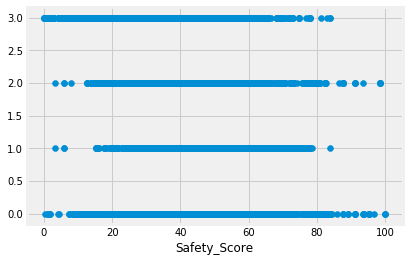

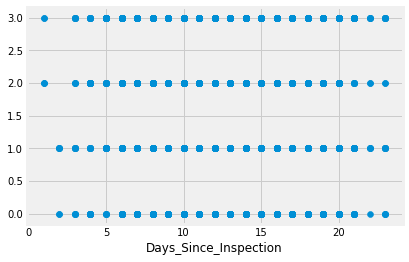

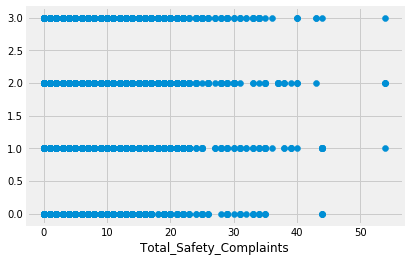

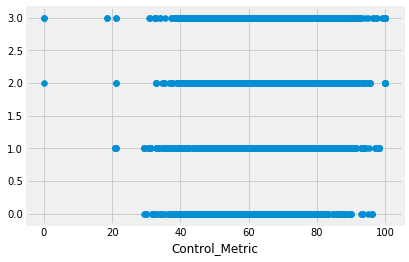

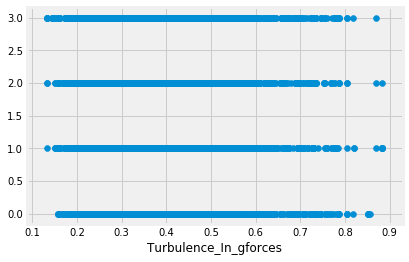

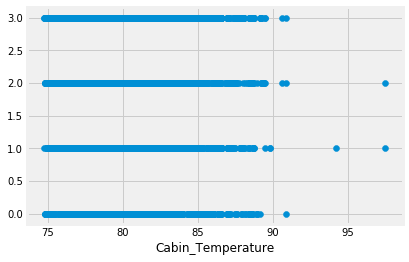

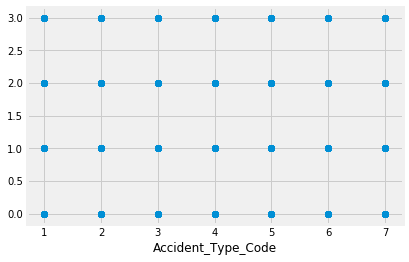

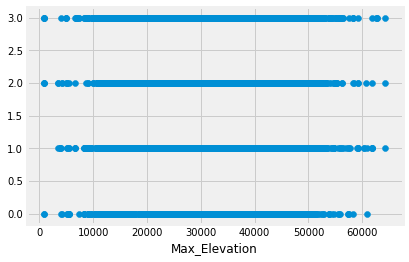

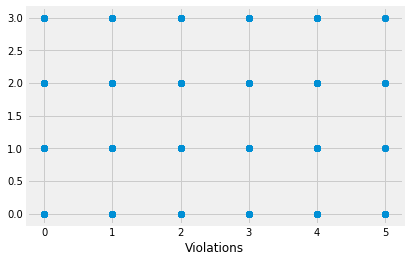

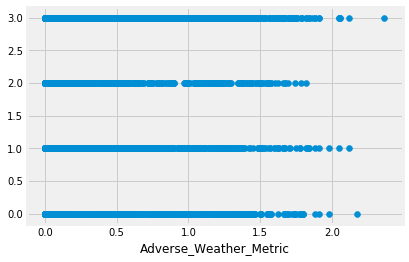

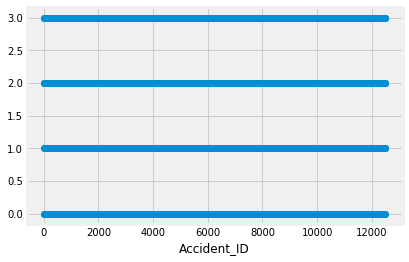

In [17]:
for i in numeric_features:
    plt.scatter(train[i], train['Severity_final'])
    plt.xlabel(xlabel=i)
    plt.show()

## Submitting data without new features 

In [18]:
test.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21


## Preprocessing

In [19]:

print("Train Shape :",train.shape,"\n Test Shape :",test.shape)

Train Shape : (10000, 12) 
 Test Shape : (2500, 11)


## Train Validation Split

In [20]:
trainX,ValidX = train_test_split(train,test_size = 0.2,shuffle = False,random_state = 13)
print("TrainX :",trainX.shape,"\nValidX :",ValidX.shape)

TrainX : (8000, 12) 
ValidX : (2000, 12)


In [21]:
target = 'Severity_final'

In [22]:
test.reset_index(drop=True, inplace=True)
feat = train.columns.tolist()
feat.remove(target)
print("Feature Length : {}".format(len(feat)))

Feature Length : 11


## Model

### Baselinear Model

In [23]:
def baseliner(train, features, target, cv=3, metric=make_scorer(metric, True)):
    print("Baseliner Models(All)")
    eval_dict = {}
    models = [
        KNeighborsRegressor(), GaussianNB(), 
        lgb.LGBMRegressor(), ExtraTreesRegressor(), xgb.XGBRegressor(objective='reg:squarederror'), 
        cat.CatBoostRegressor(verbose=0), GradientBoostingRegressor(), RandomForestRegressor(), 
        LinearRegression(), DecisionTreeRegressor(), ExtraTreeRegressor(), AdaBoostRegressor(), 
        BaggingRegressor(), ElasticNet(), Lasso(), Ridge(), 
        ] #SVR(), 

    print("sklearn Model Name  \t  CV")
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, train[features], train[target], cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))

In [24]:
tscv = TimeSeriesSplit(n_splits=3)

In [25]:
baseliner(train,feat,target,cv=tscv,metric=make_scorer(metric,True))

Baseliner Models(All)
sklearn Model Name  	  CV
----------------------------------------------------------------------------------------------------
KNeighborsRegressor 	 99.4836 	
GaussianNB 	 99.4462 	
LGBMRegressor 	 99.8199 	
ExtraTreesRegressor 	 99.7957 	
XGBRegressor 	 99.7853 	
<catboost.core.CatBoo 	 99.8214 	
GradientBoostingRegre 	 99.7868 	
RandomForestRegressor 	 99.8208 	
LinearRegression 	 99.5734 	
DecisionTreeRegressor 	 99.7898 	
ExtraTreeRegressor 	 99.7030 	
AdaBoostRegressor 	 99.6242 	
BaggingRegressor 	 99.8223 	
ElasticNet 	 99.5594 	
Lasso 	 99.5393 	
Ridge 	 99.5734 	


## Light GBM

In [26]:
def lgb_model(train, features, target, ts=False, plot=True):
    evals_result = {}
    trainX, validX, trainY, validY = train_test_split(train[features], train[target], shuffle=False, test_size=0.2, random_state=13)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 1111
    lgb_params = {
        "boosting": 'dart',
        "learning_rate": 0.1,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "regression",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=250,
        verbose_eval=100,
        evals_result=evals_result,
        feval=metric_lgb # New metric to be optimised
    )
    if plot:
        lgb.plot_importance(lgb_model, figsize=(24, 24))
        lgb.plot_metric(evals_result, metric='100-rmse')

    return lgb_model, lgb_model.best_score

LGB Model
[100]	training's l2: 0.198278	training's 100-rmse: 99.8266	valid_1's l2: 0.187825	valid_1's 100-rmse: 99.8274
[200]	training's l2: 0.129749	training's 100-rmse: 99.8505	valid_1's l2: 0.133469	valid_1's 100-rmse: 99.8418
[300]	training's l2: 0.0847945	training's 100-rmse: 99.8726	valid_1's l2: 0.109027	valid_1's 100-rmse: 99.8479
[400]	training's l2: 0.0626635	training's 100-rmse: 99.8874	valid_1's l2: 0.0997864	valid_1's 100-rmse: 99.8519
[500]	training's l2: 0.0537414	training's 100-rmse: 99.8942	valid_1's l2: 0.0958042	valid_1's 100-rmse: 99.8532
[600]	training's l2: 0.0430908	training's 100-rmse: 99.9028	valid_1's l2: 0.0925072	valid_1's 100-rmse: 99.8541
[700]	training's l2: 0.0423211	training's 100-rmse: 99.9049	valid_1's l2: 0.0916705	valid_1's 100-rmse: 99.8557
[800]	training's l2: 0.0366336	training's 100-rmse: 99.9101	valid_1's l2: 0.0911635	valid_1's 100-rmse: 99.8551
[900]	training's l2: 0.0295633	training's 100-rmse: 99.9186	valid_1's l2: 0.0893729	valid_1's 100-r

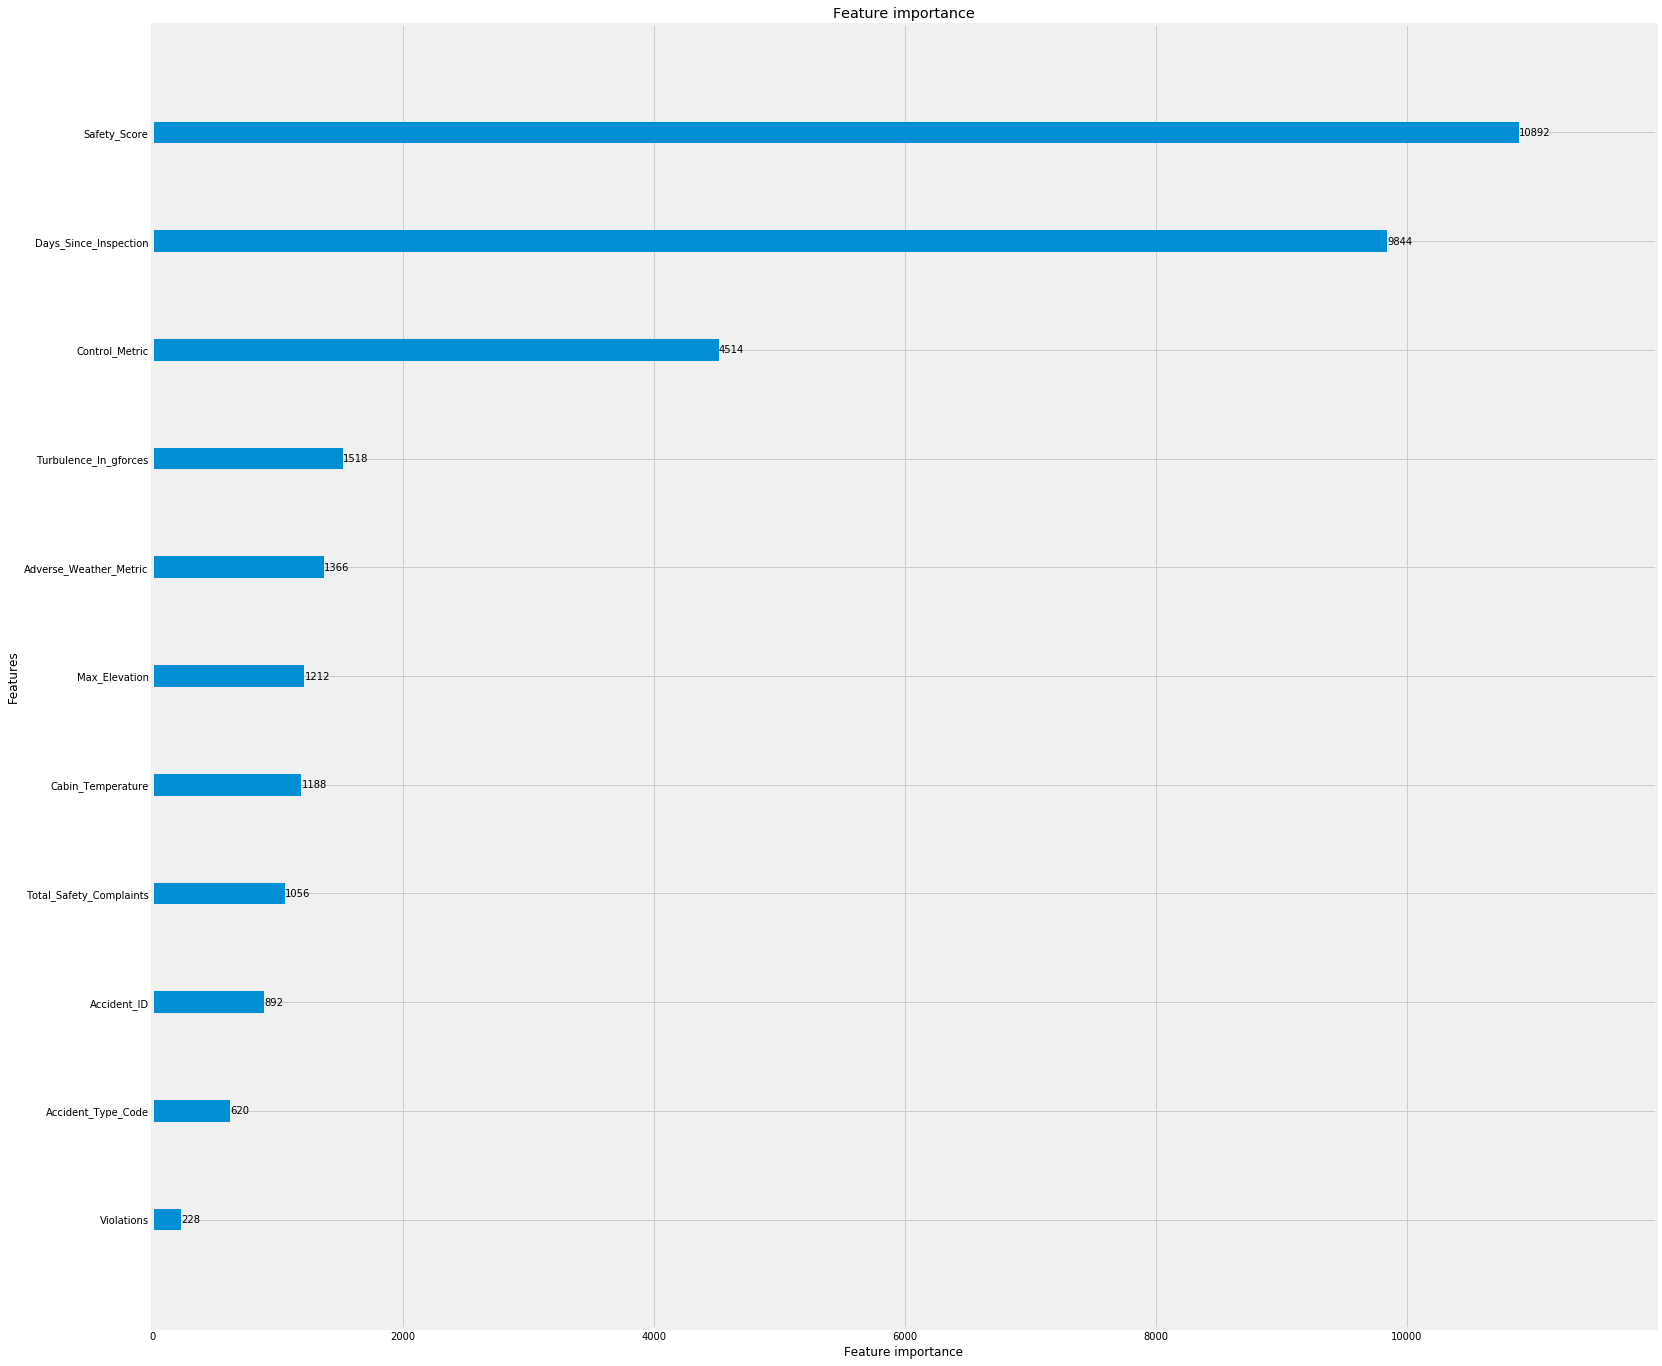

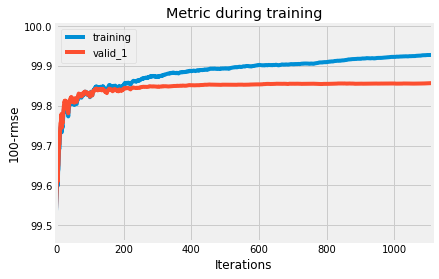

In [27]:
lgbM, score = lgb_model(train,feat,target,True,True)

## Train On Full DATA

In [28]:
lgbtrain = lgb.Dataset(train[feat],label = train[target])

In [29]:
MAX_ROUNDS = 1111
lgb_params = {
    "boosting": 'dart',
    "learning_rate": 0.1,
    "nthread": -1,
    "seed": 13,
    "num_boost_round": MAX_ROUNDS,
    "objective": "regression",
    'min_split_gain': 0,
}

In [30]:
lgb_model = lgb.train(
    lgb_params,
    train_set=lgbtrain,
    verbose_eval=100,
    feval=metric_lgb, # New metric to be optimised
)

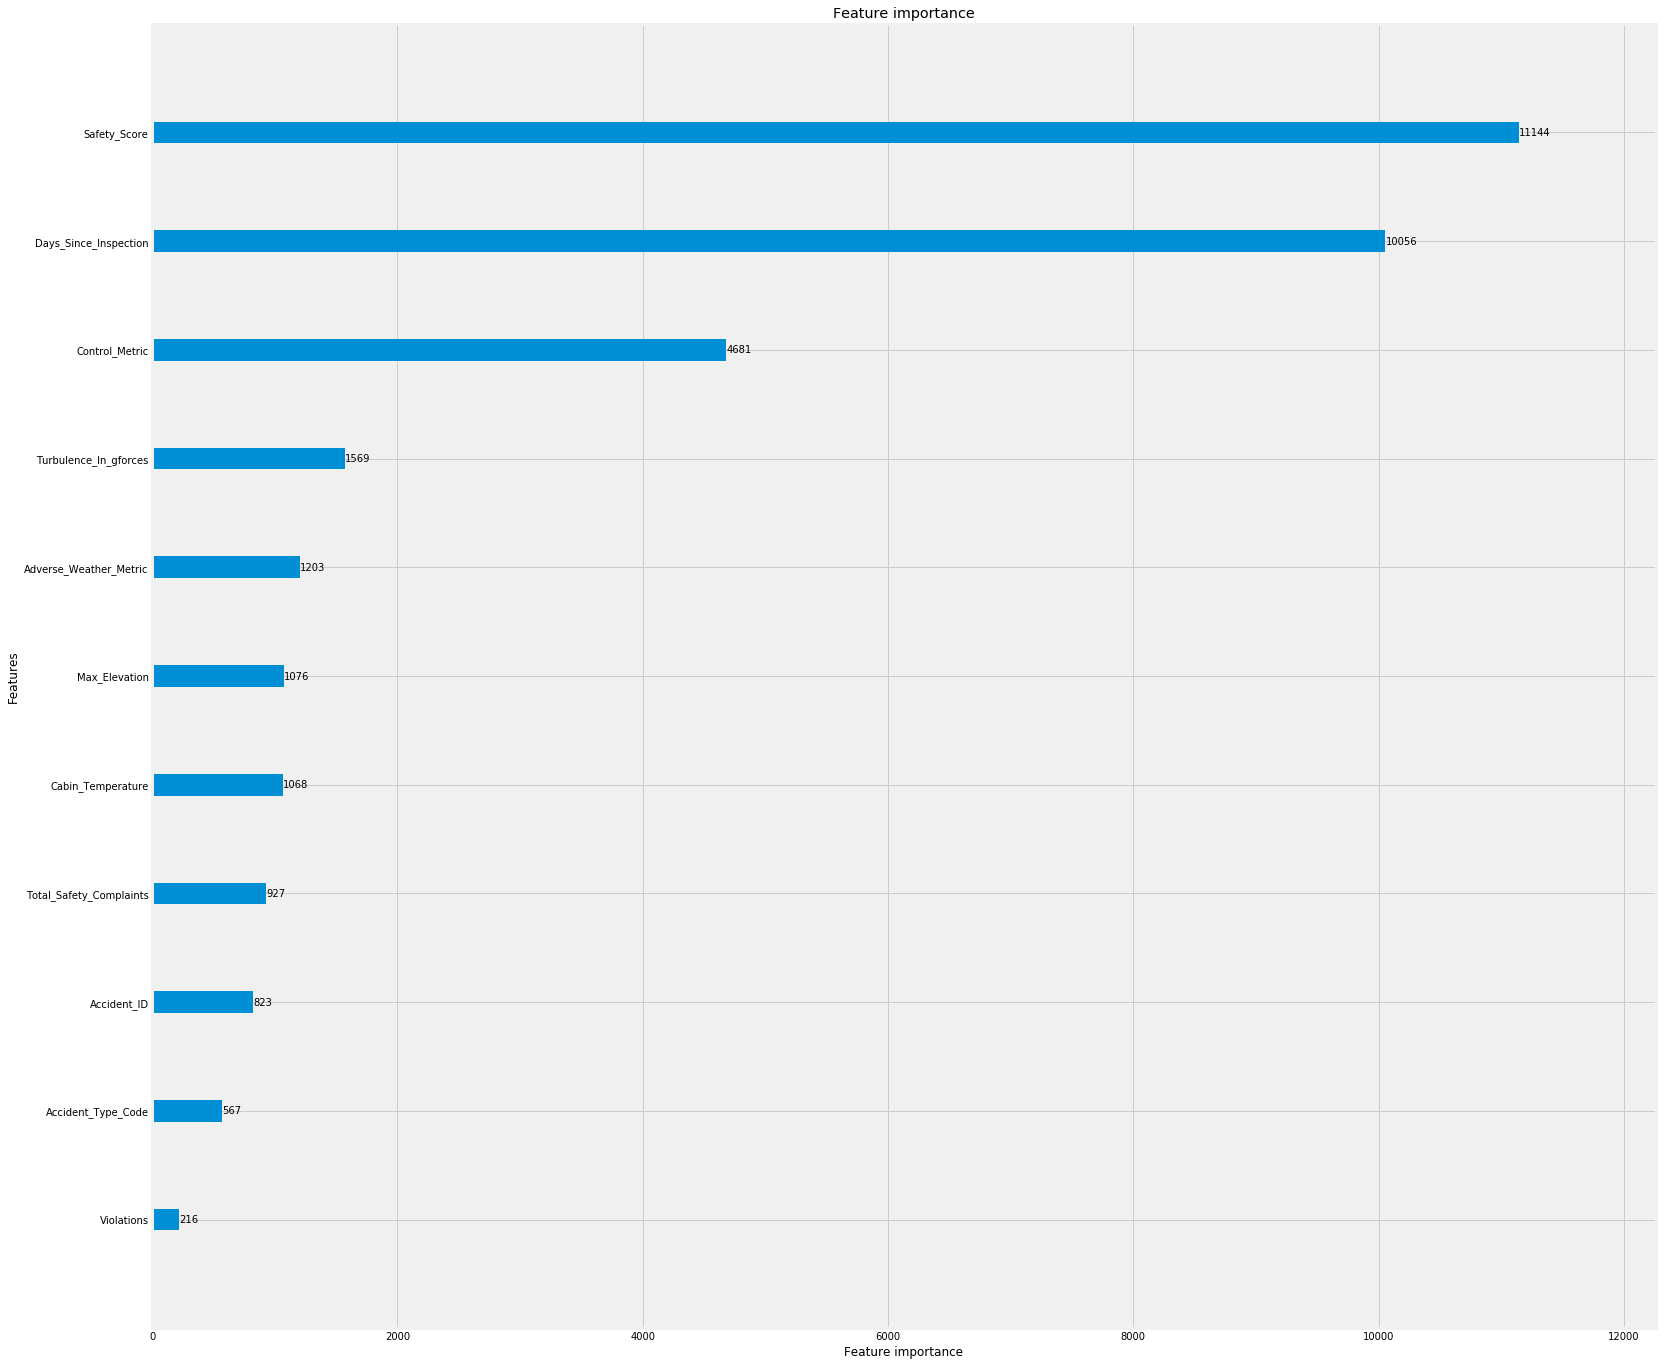

In [31]:
lgb.plot_importance(lgb_model, figsize=(24, 24))

In [46]:
y_preds = (lgb_model.predict(test[feat])).astype(int)
test[target] = y_preds
test[target].head()

0    2
1    0
2    1
3    2
4    0
Name: Severity_final, dtype: int64

In [47]:
test.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID,Severity_final
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1,2
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10,0
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14,1
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17,2
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21,0


In [48]:
sub = test['Accident_ID']
sub = pd.DataFrame(sub)

In [49]:
sub['Severity'] = test['Severity_final']

In [50]:
def target(x):
    if (x=='Significant_Damage_And_Fatalities'):
        return 0
    if (x=='Minor_Damage_And_Injuries'):
        return 1
    if (x=='Significant_Damage_And_Serious_Injuries'):
        return 2
    if (x=='Highly_Fatal_And_Damaging'):
        return 3

In [51]:
sub['Severity'] = sub.Severity.map({0:"Significant_Damage_And_Fatalities",1:"Minor_Damage_And_Injuries",2:"Significant_Damage_And_Serious_Injuries",3:"Highly_Fatal_And_Damaging"})

In [53]:
sub.Severity.value_counts()

Significant_Damage_And_Serious_Injuries    953
Minor_Damage_And_Injuries                  798
Significant_Damage_And_Fatalities          719
Highly_Fatal_And_Damaging                   30
Name: Severity, dtype: int64

In [54]:
sub.to_csv("Submission.csv",index=False)